In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from IPython.display import HTML
import random

In [12]:
"""
REWARDS:
       0    0     0     0     0    1
    T <- A <-> B <-> C <-> D <-> E -> T
"""

ACTIONS = {'left':0, 'right':1}
STATES = ['Terminal_Left', 'A', 'B', 'C', 'D', 'E', 'Terminal_Right']
VALUES = [0, 0.5, 0.5, 0.5, 0.5, 0.5, 0]

ALPHA = 0.1
GAMMA = 1

TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0

In [10]:
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)


In [15]:
hide_toggle(for_next=False)

In [14]:
def Temporal_Difference(values, start_state='C', alpha=ALPHA, gamma=GAMMA):

    current_state_index = STATES.index(start_state)
    trajectory = [start_state]
    rewards = []
    
    while True:        
        if current_state_index == 0 or current_state_index == 6:
            break
            
        old_state_index = current_state_index
        
        if np.random.binomial(1, 0.5) == ACTIONS['left']:
            current_state_index -= 1
        else:
            current_state_index += 1
            
        if current_state_index == 6:
            reward = 1
        else:
            reward = 0
            
        trajectory.append(STATES[current_state_index])
        
        values[old_state_index] += alpha * (reward + gamma * values[current_state_index] - values[old_state_index])
        rewards.append(reward)
        
    return trajectory, rewards      


In [4]:
def Alpha_Monte_Carlo(values, start_state='C', alpha=ALPHA, gamma=GAMMA):
    
    current_state_index = STATES.index(start_state)
    trajectory = [start_state]
    rewards = [0]
    
    while True:
        reward = 0
        
        if current_state_index == 0 or current_state_index == 6:
            break      
            
        if np.random.binomial(1, 0.5) == ACTIONS['left']:
            current_state_index -= 1
        else:
            current_state_index += 1
           
        if current_state_index == 6:
            reward = 1
            
        trajectory.append(STATES[current_state_index])
        rewards.append(reward)
            
#     print(trajectory)
#     print(rewards)
    
    # at the end of episode, get the value of each state
    # first, calculate the returns for each state
    returns = []
    G = 0
    for i in range(len(rewards)-1,-1,-1): #backward
        G = gamma * G + rewards[i]
        returns.append(G)        
    returns.reverse()
    
    for i, state in enumerate(trajectory[:-1]):
        idx = STATES.index(state)
        values[idx] += alpha * (returns[i] - values[idx]) 
     
    return trajectory, returns
     

In [5]:
def State_Value():
    episodes = [0, 1, 10, 100]
    current_values = np.copy(VALUES)
    plot_values = {}
    
    for i in range(episodes[-1] + 1):
        if i in episodes:
            plot_values[i] = current_values.tolist()    
            
        trajectory, x = Temporal_Difference(current_values)
        
        bar = '-' * 20
        print(bar + ' episode %d'%(i + 1) + ' ' + bar)
        print('Trajectory: ', trajectory)
        print('Values: ', current_values)    
        
    return plot_values
        

In [6]:
def RMS_Error(method, episodes=100):
    td_alphas = [0.05, 0.1, 0.15]
    mc_alphas = [0.01, 0.02, 0.03, 0.04]    
    alphas = []
    total_errors = {}
    runs = 100
    
    if method == 'TD':
        alphas = td_alphas
    elif method == 'MC':
        alphas = mc_alphas
        
    for index, alpha in enumerate(alphas):
        errors = np.zeros(episodes)     
        
        for run in tqdm(range(runs)):
            run_error = []
            current_values = np.copy(VALUES)   
        
            for episode in range(episodes):                   
                run_error.append(np.sqrt(np.sum(np.power(TRUE_VALUE - current_values, 2)) / 5.0))            
                if method == 'TD':
                    Temporal_Difference(current_values, alpha=alpha)
                elif method == 'MC':
                    Alpha_Monte_Carlo(current_values, alpha=alpha)
            errors += np.asarray(run_error)   

        total_errors[alpha] = (errors / runs).tolist() 
        
    return  total_errors


In [7]:
def Plot_State_Value(values):
    plt.figure(figsize=(10, 7))
    
    for episode, value in values.items():
        plt.plot(value, marker='o', label=str(episode)+' episodes')
        
    plt.plot(TRUE_VALUE, marker='o', label='true values')
    plt.xlabel('state')
    plt.ylabel('estimated value')
    plt.legend()

In [8]:
def Plot_RMS_Error():
    plt.figure(figsize=(10, 7))
    
    td_errors = RMS_Error('TD')  
    for alpha, errors in td_errors.items():
        plt.plot(errors, linestyle='solid', label='TD, alpha = %.02f' % (alpha)) 
    
    mc_errors = RMS_Error('MC')    
    for alpha, errors in mc_errors.items():
        plt.plot(errors, linestyle='dashdot', label='MC, alpha = %.02f' % (alpha))     
    
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()

In [9]:
plot_values = State_Value()

-------------------- episode 1 --------------------
Trajectory:  ['C', 'B', 'C', 'B', 'A', 'Terminal_Left']
Values:  [0.   0.45 0.5  0.5  0.5  0.5  0.  ]
-------------------- episode 2 --------------------
Trajectory:  ['C', 'D', 'E', 'D', 'E', 'Terminal_Right']
Values:  [0.   0.45 0.5  0.5  0.5  0.55 0.  ]
-------------------- episode 3 --------------------
Trajectory:  ['C', 'B', 'C', 'D', 'C', 'D', 'E', 'Terminal_Right']
Values:  [0.    0.45  0.5   0.5   0.505 0.595 0.   ]
-------------------- episode 4 --------------------
Trajectory:  ['C', 'D', 'E', 'D', 'E', 'Terminal_Right']
Values:  [0.      0.45    0.5     0.5005  0.52129 0.62821 0.     ]
-------------------- episode 5 --------------------
Trajectory:  ['C', 'D', 'E', 'Terminal_Right']
Values:  [0.       0.45     0.5      0.502579 0.531982 0.665389 0.      ]
-------------------- episode 6 --------------------
Trajectory:  ['C', 'B', 'A', 'Terminal_Left']
Values:  [0.        0.405     0.495     0.5023211 0.531982  0.665389  0.

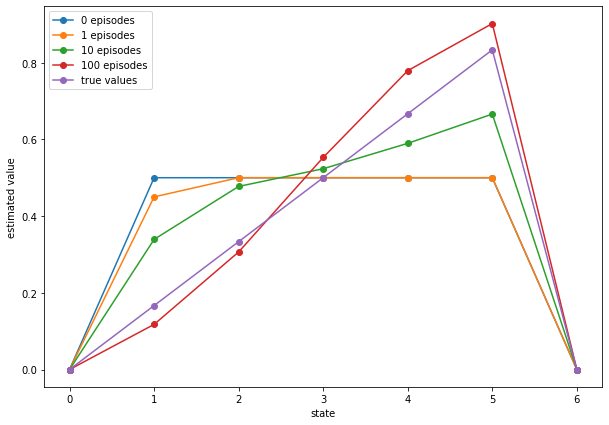

In [10]:
Plot_State_Value(plot_values)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 178.55it/s]


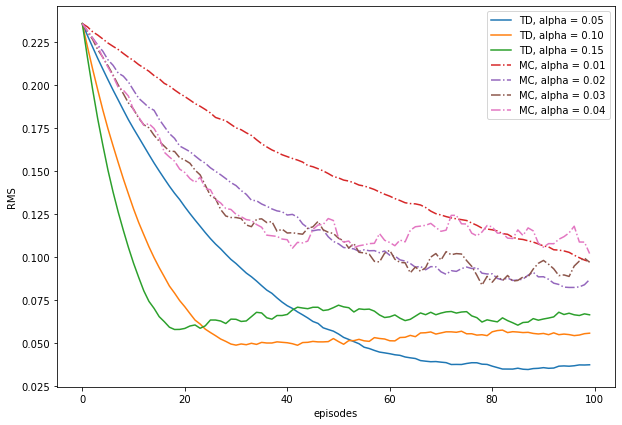

In [11]:
Plot_RMS_Error()

# Example 6.3 Bactch Updating

In [19]:
def Batch_Updating(method, episodes=1000, alpha=0.001):
    # each batch perform 100 independent runs

    runs = 100
            
    errors = np.zeros(episodes)     

    for run in tqdm(range(runs)):
        run_error = []
        current_values = np.copy(VALUES)   

        for episode in range(episodes):                   
            run_error.append(np.sqrt(np.sum(np.power(TRUE_VALUE - current_values, 2)) / 5.0))            
            if method == 'TD':
                Temporal_Difference(current_values, alpha=alpha)
            elif method == 'MC':
                Alpha_Monte_Carlo(current_values, alpha=alpha)
        errors += np.asarray(run_error)   

    errors /= runs 
        
    return  errors.tolist()


In [25]:
def Plot_Batch_Updating(alpha=0.01):
    plt.figure(figsize=(10, 7))    

    plt.plot(Batch_Updating('TD', alpha=alpha), linestyle='solid', label='TD')
    plt.plot(Batch_Updating('MC', alpha=alpha), linestyle='dashdot', label='MC')     
    
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.08it/s]


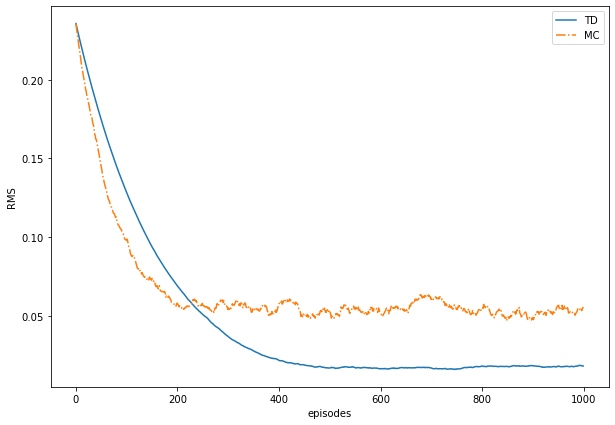

In [28]:
Plot_Batch_Updating(alpha=0.01)